# Grouping **LOGIC** dataset class labels using classification probabilities

- In this notebook, we use kmeans to make groups of **LOGIC** dataset class labels

# Environment Setup

In [1]:
# Mount Google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# Clone `CreateDebateScraper` library from github
!git clone https://github.com/utkarsh512/CreateDebateScraper.git
%cd CreateDebateScraper/src/nested

Cloning into 'CreateDebateScraper'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 176 (delta 5), reused 4 (delta 4), pack-reused 170
Receiving objects: 100% (176/176), 207.95 KiB | 23.11 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/CreateDebateScraper/src/nested


In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from thread import (Comment, 
                    Thread)

from tqdm import tqdm
import pickle
from pprint import pprint
from copy import deepcopy

In [51]:
# Setup for plotting
sns.set(style="darkgrid")
matplotlib.rcParams["figure.dpi"] = 120
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams["figure.figsize"] = (12, 5)

# Downloading classification probabilities

In [21]:
# Encoding labels used while classification.
# Refer to notebook#63.
label_map = {
    'faulty generalization': 0,
    'false causality': 1,
    'circular reasoning': 2, 
    'ad populum': 3,
    'ad hominem': 4,
    'fallacy of logic': 5,
    'appeal to emotion': 6,
    'false dilemma': 7,
    'equivocation': 8,
    'fallacy of extension': 9,
    'fallacy of relevance': 10,
    'fallacy of credibility': 11,
    'intentional': 12,
}

inverse_label_map = dict()
for k, v in label_map.items():
    inverse_label_map[v] = k

In [55]:
def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [9]:
# Load labels and scores obtained during classification 
for_against_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-for_against_labels_and_scores.pkl')
perspective_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-perspective_labels_and_scores.pkl')

In [12]:
for_against_labels_and_scores[0]

[{'label': 'LABEL_5', 'score': 0.3989153802394867},
 {'label': 'LABEL_12', 'score': 0.23682057857513428},
 {'label': 'LABEL_10', 'score': 0.11046063154935837},
 {'label': 'LABEL_0', 'score': 0.07518979907035828},
 {'label': 'LABEL_7', 'score': 0.04555338993668556},
 {'label': 'LABEL_8', 'score': 0.044705830514431},
 {'label': 'LABEL_6', 'score': 0.028932960703969002},
 {'label': 'LABEL_2', 'score': 0.0229534599930048},
 {'label': 'LABEL_1', 'score': 0.014680683612823486},
 {'label': 'LABEL_4', 'score': 0.01029952708631754},
 {'label': 'LABEL_9', 'score': 0.004900992847979069},
 {'label': 'LABEL_11', 'score': 0.004005727358162403},
 {'label': 'LABEL_3', 'score': 0.002580963773652911}]

# K-means clustering

Each comment is represented as a 13-dimensional ordered vector, one dimension for each class label with its value being the classification probability.


In [15]:
def get_feature_vectors_for_kmeans(labels_and_scores):
    """Convert the pickled objects to ``numpy`` 2d arrays
    :param labels_and_scores: object loaded with ``load_obj()``
    """
    feature_vectors = list()
    for labels_and_scores_per_vec in labels_and_scores:
        feature_vector = [None for _ in range(len(label_map))]
        for label_and_score in labels_and_scores_per_vec:
            label_code = int(label_and_score['label'].lstrip('LABEL_'))
            feature_vector[label_code] = label_and_score['score']
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

In [56]:
def explain_kmeans_cluster_centers(cluster_centers):
    """Compute the composition of each class label in the cluster centers
    returned by ``kmeans`` algorithm
    :param cluster_centers: ``cluster_centers_`` attribute of ``sklearn`` kmeans
    """ 
    normalized_cluster_centers = normalize(cluster_centers, axis=1, norm='l1')
    n_centres, n_features = cluster_centers.shape
    data = { 'centers': list() }
    for i in range(n_features):
        data[ inverse_label_map[i] ] = list()

    # Fill ``data`` and print the composition, ordered by weights
    for i in range(n_centres):
        scores = list()
        for j in range(n_features):
            scores.append((inverse_label_map[j], normalized_cluster_centers[i, j]))
        scores = sorted(scores, reverse=True, key=lambda z: z[1])
        data['centers'].append(f'center_{i + 1}')
        for label, weight in scores:
            data[label].append(weight)
        print(f'Center {i + 1}: ' + ', '.join((f'{label_name}: {label_weight:.2f}' for label_name, label_weight in scores)))

    # Plot the composition as stacked bar plot
    df = pd.DataFrame(data)
    ax = df.plot.bar(stacked=True)
    ax.set_title("Composition of class labels in kmeans++ centers", color='black')
    ax.set_xlabel('kmeans++ centers')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.plot()

In [16]:
for_against_kmeans_vectors = get_feature_vectors_for_kmeans(for_against_labels_and_scores)
perspective_kmeans_vectors = get_feature_vectors_for_kmeans(perspective_labels_and_scores)

In [57]:
def run_kmeans_pipeline(feature_vectors, n_clusters):
    """KMeans pipeline for this notebook
    :param feature_vectors: ``numpy`` 2d arrays, use 
                            ``get_feature_vectors_for_kmeans()`` to generate it
    :param n_clusters: Number of clusters required in KMeans
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(feature_vectors)
    print(f'Loss funtion = {kmeans.inertia_: .4f}')
    explain_kmeans_cluster_centers(kmeans.cluster_centers_)

Loss funtion =  18686.9126
Center 1: fallacy of relevance: 0.17, ad hominem: 0.15, intentional: 0.15, fallacy of logic: 0.13, faulty generalization: 0.06, circular reasoning: 0.06, appeal to emotion: 0.06, fallacy of extension: 0.05, ad populum: 0.04, false causality: 0.04, equivocation: 0.03, fallacy of credibility: 0.03, false dilemma: 0.02
Center 2: faulty generalization: 0.67, fallacy of logic: 0.09, fallacy of relevance: 0.05, ad hominem: 0.04, false causality: 0.03, appeal to emotion: 0.03, ad populum: 0.02, fallacy of extension: 0.02, intentional: 0.02, circular reasoning: 0.01, equivocation: 0.01, false dilemma: 0.01, fallacy of credibility: 0.00


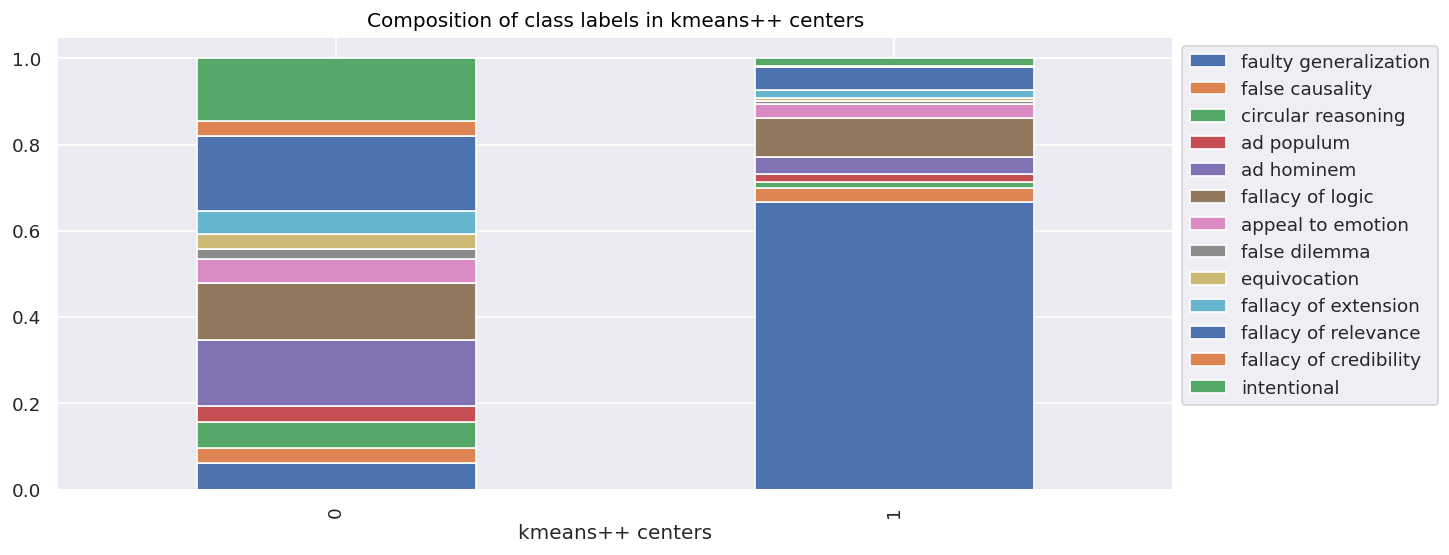

In [59]:
run_kmeans_pipeline(for_against_kmeans_vectors, n_clusters=2)

Loss funtion =  10454.8972
Center 1: faulty generalization: 0.69, fallacy of logic: 0.08, fallacy of relevance: 0.05, ad hominem: 0.04, false causality: 0.03, appeal to emotion: 0.03, ad populum: 0.02, fallacy of extension: 0.02, intentional: 0.02, circular reasoning: 0.01, equivocation: 0.01, false dilemma: 0.01, fallacy of credibility: 0.00
Center 2: fallacy of relevance: 0.26, appeal to emotion: 0.09, fallacy of extension: 0.09, intentional: 0.09, faulty generalization: 0.08, fallacy of logic: 0.07, ad hominem: 0.07, ad populum: 0.06, false causality: 0.05, fallacy of credibility: 0.05, false dilemma: 0.03, equivocation: 0.03, circular reasoning: 0.03
Center 3: ad hominem: 0.70, fallacy of relevance: 0.08, intentional: 0.07, faulty generalization: 0.05, fallacy of extension: 0.04, circular reasoning: 0.01, fallacy of logic: 0.01, false dilemma: 0.01, fallacy of credibility: 0.01, ad populum: 0.01, appeal to emotion: 0.01, equivocation: 0.01, false causality: 0.01
Center 4: fallacy o

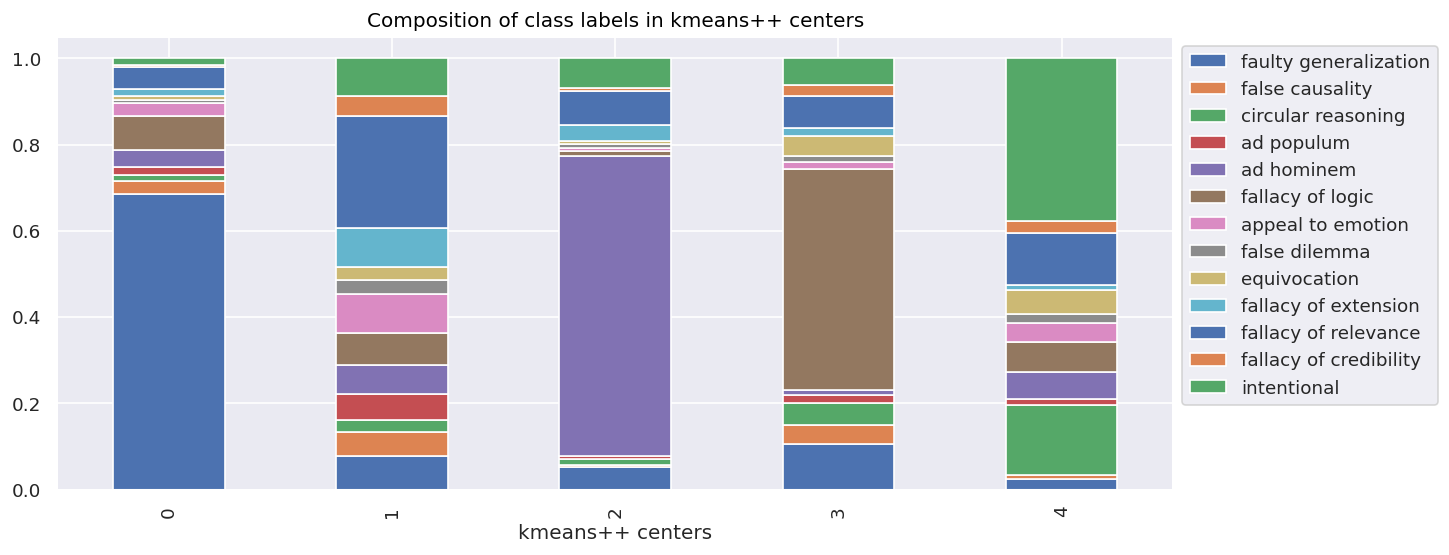

In [67]:
run_kmeans_pipeline(for_against_kmeans_vectors, n_clusters=5)

Loss funtion =  3902.7986
Center 1: fallacy of relevance: 0.24, fallacy of extension: 0.11, appeal to emotion: 0.09, intentional: 0.08, ad populum: 0.08, faulty generalization: 0.07, ad hominem: 0.07, fallacy of logic: 0.06, false causality: 0.06, fallacy of credibility: 0.05, circular reasoning: 0.03, false dilemma: 0.03, equivocation: 0.03
Center 2: intentional: 0.43, circular reasoning: 0.13, fallacy of relevance: 0.13, ad hominem: 0.07, fallacy of logic: 0.06, equivocation: 0.04, appeal to emotion: 0.04, fallacy of credibility: 0.02, false dilemma: 0.02, faulty generalization: 0.02, ad populum: 0.01, fallacy of extension: 0.01, false causality: 0.01
Center 3: fallacy of logic: 0.49, faulty generalization: 0.10, fallacy of relevance: 0.08, intentional: 0.07, false causality: 0.05, circular reasoning: 0.05, equivocation: 0.04, fallacy of credibility: 0.03, ad populum: 0.03, fallacy of extension: 0.02, appeal to emotion: 0.02, false dilemma: 0.02, ad hominem: 0.01
Center 4: ad hominem

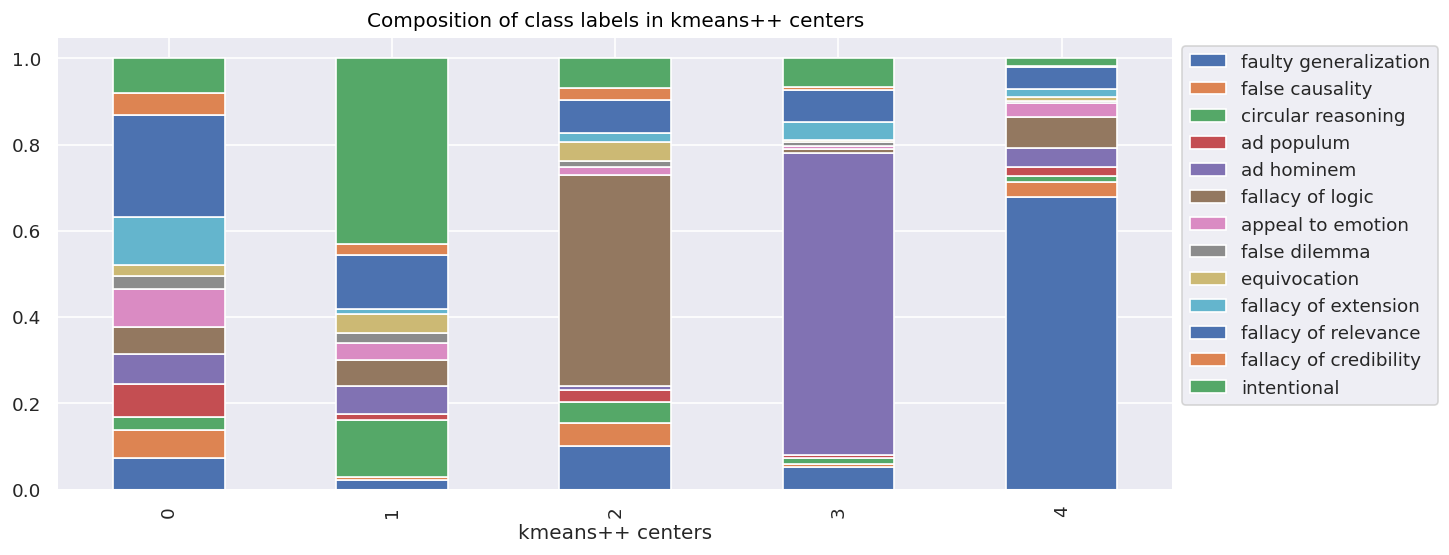

In [68]:
run_kmeans_pipeline(perspective_kmeans_vectors, n_clusters=5)